In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning/NASNet-large.h5
/kaggle/input/deep-learning/NASNet-mobile-no-top.h5
/kaggle/input/deep-learning/efficientnetb0_notop.h5
/kaggle/input/deep-learning/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/deep-learning/xception_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/deep-learning/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/deep-learning/test/test/Image_747.jpg
/kaggle/input/deep-learning/test/test/Image_561.jpg
/kaggle/input/deep-learning/test/test/Image_345.jpg
/kaggle/input/deep-learning/test/test/Image_844.jpg
/kaggle/input/deep-learning/test/test/Image_270.jpg
/kaggle/input/deep-learning/test/test/Image_526.jpg
/kaggle/input/deep-learning/test/test/Image_968.jpg
/kaggle/input/deep-learning/test/test/Image_322.jpg
/kaggle/input/deep-learning/test/test/Image_860.jpg
/kaggle/input/deep-learning/test/test/Image_1103.jpg
/kaggle/input/deep-learning/test/test/Image_574.jpg
/kaggle/input/deep-learning/test

In [2]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import InceptionV3
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

2024-07-12 03:23:36.264187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 03:23:36.264326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 03:23:36.426990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import NASNetMobile
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
train_folder = "/kaggle/input/deep-learning/train/train"
test_folder = "/kaggle/input/deep-learning/test/test"

In [5]:
train_csv = "/kaggle/input/deep-learning/Training_set/Training_set.csv"


In [6]:
labels = pd.read_csv(train_csv)

In [7]:
## Hyperparameter
image_size = (256, 256)
batch_size = 32
learning_rate = 0.001

In [8]:
validation_split = 0.8
idxs = np.random.permutation(range(len(labels))) < validation_split*len(labels)

train_labels = labels[idxs]
val_labels = labels[~idxs]
print(len(train_labels), len(val_labels))

4000 1000


In [9]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255, horizontal_flip=True, 
                                                             rotation_range=30,
                                                             shear_range=0.2,
                                                             height_shift_range=0.2,
                                                             width_shift_range=0.2,
                                                             vertical_flip=True,
                                                            fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(train_labels,directory=train_folder,x_col='filename',
                                                    y_col='label',class_mode='categorical',batch_size=32,
                                                    target_size=(256, 256))
val_generator = train_datagen.flow_from_dataframe(val_labels,directory=train_folder,x_col='filename',
                                                    y_col='label',class_mode='categorical',batch_size=32,
                                                    target_size=(256, 256))

train_data = train_datagen.flow_from_dataframe(labels, directory = train_folder,x_col='filename',
                                                    y_col='label',class_mode='categorical',batch_size=32,
                                                    target_size=(256, 256))

Found 4000 validated image filenames belonging to 75 classes.
Found 1000 validated image filenames belonging to 75 classes.
Found 5000 validated image filenames belonging to 75 classes.


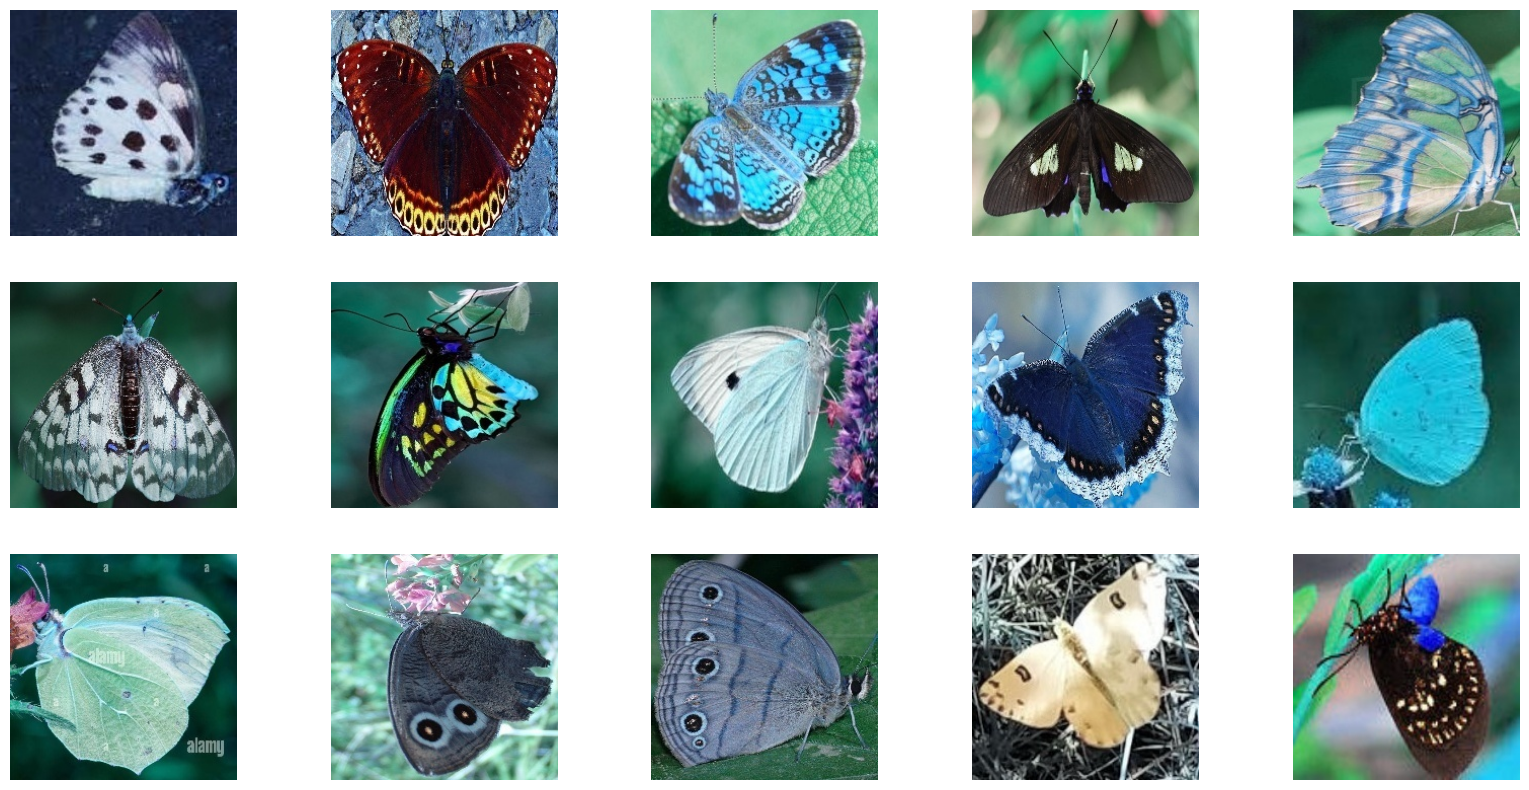

In [10]:
rand_images = random.sample(os.listdir(train_folder), 15)

fig = plt.figure(figsize=(20,10))
for i, im in enumerate(rand_images):
    plt.subplot(3, 5, i+1)
    im = cv2.imread(os.path.join(train_folder, im))
    plt.imshow(im)
    plt.axis('off')
plt.show()

In [11]:
from tensorflow.keras.applications import InceptionV3

weights_path = '/kaggle/input/deep-learning/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Tạo mô hình NASNetLarge với cấu hình tương ứng
base_model = InceptionV3(weights=None, include_top=False, input_shape=(256, 256, 3))

# Nạp trọng số vào mô hình
base_model.load_weights(weights_path)

In [12]:
# Freeze layers except the last few
num_layers_to_train = int(np.ceil(0.1 * len(base_model.layers)))
for layer in base_model.layers[:-num_layers_to_train]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
predictions = Dense(75, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with adjusted learning rate parameter
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 40,696,683 (155.25 MB)

 Trainable params: 24,967,435 (95.24 MB)

 Non-trainable params: 15,729,248 (60.00 MB)

In [13]:
learning_rate = 0.001

# Compile the model with adjusted learning rate parameter
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
#early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Calculate training time
start_time = time.time()

# Train the model with model checkpoint
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    verbose=1,
    callbacks=[model_checkpoint], # without early stopping
    batch_size=32,
)

# Calculate and print the total training time
end_time = time.time()
total_time = end_time - start_time
print(f"Training time: {total_time:.2f} seconds")

# Unlock the last 10 layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
model.fit(train_generator, epochs=15, validation_data=val_generator)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 455s 4s/step - accuracy: 0.0881 - loss: 12.7204 - val_accuracy: 0.4320 - val_loss: 3.7156
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.4806 - loss: 3.1485 - val_accuracy: 0.6740 - val_loss: 1.9443
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.7237 - loss: 1.6750 - val_accuracy: 0.7050 - val_loss: 1.5882
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 440s 3s/step - accuracy: 0.7807 - loss: 1.2853 - val_accuracy: 0.7540 - val_loss: 1.3714
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 441s 3s/step - accuracy: 0.8130 - loss: 1.1320 - val_accuracy: 0.7370 - val_loss: 1.4307
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.8022 - loss: 1.1085 - val_accuracy: 0.7820 - val_loss: 1.2528
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.8286 - loss: 1.0116 - val_accuracy: 0.7950 - val_loss: 1.1599
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.8638 - loss: 0.8668 - val_acc

In [14]:
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss =  history.history['val_loss'][-1]

In [15]:
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")

Final Training Accuracy: 96.22%


In [16]:
print(f"Final Valication Accuracy: {final_val_accuracy * 100:.2f}%")

Final Valication Accuracy: 84.10%


In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

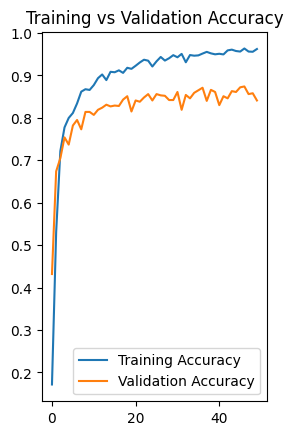

In [18]:
import matplotlib.pyplot as plt


plt.subplot(1, 2, 1)  # Create subplot 1 in a 1x2 grid
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.show()  # Display the plot


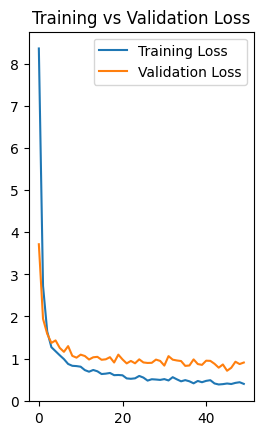

In [19]:
plt.subplot(1, 2, 2)  # Create subplot 1 in a 1x2 grid
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")

plt.show()  # Display the plot

<h2><strong>Test

In [20]:
test_loss, test_acc = model.evaluate(train_data)
print(f"Test accuracy: {test_acc}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 376s 2s/step - accuracy: 0.9709 - loss: 0.2816
Test accuracy: 0.972000002861023


In [21]:
test_dir = "/kaggle/input/deep-learning/test"
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the test generator with the correct target_size
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),  # Ensure target_size matches the input shape of your model
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 1499 images belonging to 1 classes.


In [22]:
# Perform predictions using the model
predictions = model.predict(test_generator, steps=len(test_generator))

# Assuming train_data is used for training and contains class indices
class_labels = list(train_data.class_indices.keys())

# Process predicted classes
predicted_classes = np.argmax(predictions, axis=1)
predicted_class_labels = [class_labels[i] for i in predicted_classes]

47/47 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step


In [23]:
import pandas as pd

# Function to extract numerical part from filename
def extract_number(filename):
    return int(filename.split('_')[1].split('.')[0])

# Get filenames from test_generator
file_names = test_generator.filenames

# Create DataFrame with filenames and predicted labels
results_df = pd.DataFrame({
    'filename': file_names,
    'predicted_label': predicted_class_labels
})

# Extract filename without directory for clarity
results_df['filename'] = results_df['filename'].apply(lambda x: x.split('/')[-1])

# Sort the DataFrame by the numerical part of the filenames
results_df['file_num'] = results_df['filename'].apply(extract_number)
results_df.sort_values(by='file_num', inplace=True)

# Create the final DataFrame in the desired format with column names 'ID' and 'label'
final_df = results_df[['filename', 'predicted_label']].rename(columns={'filename': 'ID', 'predicted_label': 'label'})

# Save results to CSV file with headers
final_df.to_csv('InceptionV3.csv', index=False, header=True)